<a href="https://colab.research.google.com/github/guidosantillan01/pytorch-distracted-drivers/blob/master/Driver_project_v1_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup dataset

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

## Upload kaggle.json 
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle competitions download -c state-farm-distracted-driver-detection

  0% 0.00/193k [00:00<?, ?B/s]
100% 193k/193k [00:00<00:00, 28.8MB/s]
  4% 149M/4.00G [00:02<01:05, 63.5MB/s]

In [0]:
!rm -r test || true
!rm -r train || true
!unzip -qq imgs.zip

rm: cannot remove 'test': No such file or directory
rm: cannot remove 'train': No such file or directory


In [0]:
# import os
# os.listdir('test')

## Run from here

In [0]:
pretrained_model = 'densenet121'
version = 'v10'

conf_optimizer = 'Adam'
conf_lr = 0.001
conf_epochs = 30
unfreeze_lr = 0.00001
unfreeze_epochs = 30

num_workers = 4
batch_size = 24
filetype = '.pt'

t1 = 'batchsize' + str(batch_size) + '_'
t2 = 'optimizer' + conf_optimizer + '_'
t3 = 'lr' + str(conf_lr) + '_'
t4 = 'epochs' + str(conf_epochs) + '_'
t5 = 'unfreezelr' + str(unfreeze_lr) + 'ep' + str(unfreeze_epochs) + '_'

filename = version+'_'+pretrained_model+'_' + t1+t2+t3+t4+t5 + filetype
print(filename)

v10_densenet121_batchsize24_optimizerAdam_lr0.001_epochs30_unfreezelr1e-05ep30_.pt


In [0]:
num_classes = 10
valid_size = 0.2

normal_size = 224
normal_mean = [0.485, 0.456, 0.406]
normal_std = [0.229, 0.224, 0.225]

inc_size = 299
inc_mean = [0.5, 0.5, 0.5]
inc_std = [0.5, 0.5, 0.5]

## 0. Initial Setup

### Tools Installation

In [0]:
### Setup Google Colabs initial configuration and imports
!pip install Pillow==4.1.1
!pip install PIL
!pip install image

!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

!pip install pretrainedmodels 

    100% |████████████████████████████████| 5.7MB 6.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 484.0MB 51.6MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b408000 @  0x7f13b91962a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.2MB/s 
    100% |████████████████████████████████| 61kB 2.4MB/s 
  Running setup.py bdist_wheel for pretrainedmodels ... - \ done
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Runnin

### Setup imports

In [0]:
## Initial imports
import torch
import numpy as np
import os

## To load data
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

## To visualize  data
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import seaborn as sns

## To manage data
import pandas as pd

## To define the model
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

## To specify the optimizer
import torch.optim as optim

## Others
import json
import time
import copy

## Cadene pretrained-models.pytorch library
import pretrainedmodels

### Test for CUDA

In [0]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA is available. Training on GPU ...


### Initialize the CNN

In [0]:
from collections import OrderedDict

### Initialize the CNN
def select_pretrained_model(pretrained_model):
    if pretrained_model == 'vgg16':
        model = models.vgg16(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
            
        classifier = nn.Sequential(OrderedDict([
                        ('fc1', nn.Linear(25088, 5000)),
                        ('relu', nn.ReLU()),
                        ('dropout', nn.Dropout(p=0.2)),
                        ('fc2', nn.Linear(5000, num_classes))
                    ]))
        
        model.classifier = classifier
        
        if conf_optimizer == 'Adam':
            optimizer = optim.Adam(model.classifier.parameters(), lr=conf_lr)
        if conf_optimizer == 'SGD':
            optimizer = optim.SGD(model.classifier.parameters(), lr=conf_lr, momentum=0.9)
        
        size = normal_size
        mean_array = normal_mean
        std_array = normal_std
        is_inception = False

        
        
        
    elif pretrained_model == 'resnet152':
        model = models.resnet152(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
            
#         fc = nn.Sequential(OrderedDict([
#                         ('fc1', nn.Linear(2048, 1024)),
#                         ('relu', nn.ReLU()),
#                         ('dropout', nn.Dropout(p=0.2)),
#                         ('fc2', nn.Linear(1024, num_classes))
#                     ]))
        fc = nn.Linear(2048, num_classes)
        model.fc = fc
        
        if conf_optimizer == 'Adam':
            optimizer = optim.Adam(model.fc.parameters(), lr=conf_lr)
        if conf_optimizer == 'SGD':
            optimizer = optim.SGD(model.fc.parameters(), lr=conf_lr, momentum=0.9)
        
        size = normal_size
        mean_array = normal_mean
        std_array = normal_std
        is_inception = False

        
        
        
        
    elif pretrained_model == 'resnet50':
        model = models.resnet50(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
            
#         fc = nn.Sequential(OrderedDict([
#                             ('fc1', nn.Linear(2048, 1024)),
#                             ('relu', nn.ReLU()),
#                             ('dropout', nn.Dropout(p=0.2)),
#                             ('fc2', nn.Linear(1024, num_classes))
#                         ]))
        fc = nn.Linear(2048, num_classes)
        model.fc = fc
        
        if conf_optimizer == 'Adam':
            optimizer = optim.Adam(model.fc.parameters(), lr=conf_lr)
        if conf_optimizer == 'SGD':
            optimizer = optim.SGD(model.fc.parameters(), lr=conf_lr, momentum=0.9)
        
        size = normal_size
        mean_array = normal_mean
        std_array = normal_std
        is_inception = False

        
        
        
    elif pretrained_model == 'densenet201':
        model = models.densenet201(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
        
#         classifier = nn.Sequential(OrderedDict([
#                             ('fc1', nn.Linear(1920, 960)),
#                             ('relu', nn.ReLU()),
#                             ('dropout', nn.Dropout(p=0.5)),
#                             ('fc2', nn.Linear(960, num_classes))
#                         ]))
        classifier = nn.Linear(1920, num_classes)
        model.classifier = classifier
        
        if conf_optimizer == 'Adam':
            optimizer = optim.Adam(model.classifier.parameters(), lr=conf_lr)
        if conf_optimizer == 'SGD':
            optimizer = optim.SGD(model.classifier.parameters(), lr=conf_lr, momentum=0.9)
        
        size = normal_size
        mean_array = normal_mean
        std_array = normal_std
        is_inception = False
            
            
            
            
    elif pretrained_model == 'densenet121':
        model = models.densenet121(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
            
#         classifier = nn.Sequential(OrderedDict([
#                             ('fc1', nn.Linear(1024, 614)),
#                             ('relu', nn.ReLU()),
#                             ('dropout', nn.Dropout(p=0.2)),
#                             ('fc2', nn.Linear(614, 307)),
#                             ('relu', nn.ReLU()),
#                             ('dropout', nn.Dropout(p=0.2)),
#                             ('fc3', nn.Linear(307, num_classes))
#                         ]))
        
        classifier = nn.Linear(1024, num_classes)
        model.classifier = classifier
        
        if conf_optimizer == 'Adam':
            optimizer = optim.Adam(model.classifier.parameters(), lr=conf_lr)
        if conf_optimizer == 'SGD':
            optimizer = optim.SGD(model.classifier.parameters(), lr=conf_lr, momentum=0.9)
        
        size = normal_size
        mean_array = normal_mean
        std_array = normal_std
        is_inception = False
        
        
        
        
    elif pretrained_model == 'inceptionv3':
        model = models.inception_v3(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False
            
#         fc = nn.Sequential(OrderedDict([
#                     ('fc1', nn.Linear(2048, 1024)),
#                     ('relu', nn.ReLU()),
#                     ('dropout', nn.Dropout(p=0.2)),
#                     ('fc2', nn.Linear(1024, num_classes)),
#                 ]))
        
        fc = nn.Linear(2048, num_classes)
        model.fc = fc
        model.AuxLogits.fc = nn.Linear(768, num_classes)
        
        if conf_optimizer == 'Adam':
            optimizer = optim.Adam(model.fc.parameters(), lr=conf_lr)
        if conf_optimizer == 'SGD':
            optimizer = optim.SGD(model.fc.parameters(), lr=conf_lr, momentum=0.9)
        
        size = inc_size
        mean_array = inc_mean
        std_array = inc_std
        is_inception = True
        
        
        
        
    elif pretrained_model == 'inceptionresnetv2':
        model = pretrainedmodels.inceptionresnetv2(pretrained='imagenet')

        for param in model.parameters():
            param.requires_grad = False
            
#         last_linear = nn.Sequential(OrderedDict([
#                     ('fc1', nn.Linear(1536, 768)),
#                     ('relu', nn.ReLU()),
#                     ('dropout', nn.Dropout(p=0.2)),
#                     ('fc2', nn.Linear(768, num_classes)),
#                 ]))
        
        last_linear = nn.Linear(1536, num_classes)
        model.last_linear = last_linear
        
        if conf_optimizer == 'Adam':
            optimizer = optim.Adam(model.last_linear.parameters(), lr=conf_lr)
        if conf_optimizer == 'SGD':
            optimizer = optim.SGD(model.last_linear.parameters(), lr=conf_lr, momentum=0.9)
    
        size = inc_size
        mean_array = inc_mean
        std_array = inc_std
        is_inception = True
        
        
        
        
        
    elif pretrained_model == 'nasnetalarge':
        model = pretrainedmodels.nasnetalarge(pretrained='imagenet')

        for param in model.parameters():
            param.requires_grad = False
            
#         fc = nn.Sequential(OrderedDict([
#                     ('fc1', nn.Linear(1920, 960)),
#                     ('relu', nn.ReLU()),
#                     ('dropout', nn.Dropout(p=0.2)),
#                     ('fc2', nn.Linear(960, num_classes)),
#                 ]))
        
        last_linear = nn.Linear(1920, num_classes)
        model.last_linear = last_linear
        
        if conf_optimizer == 'Adam':
            optimizer = optim.Adam(model.last_linear.parameters(), lr=conf_lr)
        if conf_optimizer == 'SGD':
            optimizer = optim.SGD(model.last_linear.parameters(), lr=conf_lr, momentum=0.9)
    
        size = inc_size
        mean_array = inc_mean
        std_array = inc_std
        is_inception = True
        
        
        
        
        
    elif pretrained_model == 'inceptionv4':
        model = pretrainedmodels.inceptionv4(pretrained='imagenet')

        for param in model.parameters():
            param.requires_grad = False
            
#         last_linear = nn.Sequential(OrderedDict([
#                     ('fc1', nn.Linear(1536, 768)),
#                     ('relu', nn.ReLU()),
#                     ('dropout', nn.Dropout(p=0.2)),
#                     ('fc2', nn.Linear(768, num_classes)),
#                 ]))
        
        last_linear = nn.Linear(1536, num_classes)
        model.last_linear = last_linear
        
        if conf_optimizer == 'Adam':
            optimizer = optim.Adam(model.last_linear.parameters(), lr=conf_lr)
        if conf_optimizer == 'SGD':
            optimizer = optim.SGD(model.last_linear.parameters(), lr=conf_lr, momentum=0.9)

        size = inc_size
        mean_array = inc_mean
        std_array = inc_std
        is_inception = True
    
    
   

        
    else:
        print('NO PRE-TRAINED MODEL DEFINED')
        
    parameters = [size, mean_array, std_array, is_inception]
    
    return model, optimizer, parameters

In [0]:
model, optimizer, parameters = select_pretrained_model(pretrained_model)
size = parameters[0]
mean_array = parameters[1]
std_array = parameters[2]
is_inception = parameters[3]
# print(model)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 84352438.05it/s]


## 1. Load and Augment the Data

### Data location

In [0]:
train_dir = 'train'
test_dir = 'test'

dirs = {
    'train': train_dir,
    'test': test_dir
}

### Data normalization

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(size),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_array,
                             std=std_array)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size + 32),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_array,
                             std=std_array)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size + 32),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_array,
                             std=std_array)
    ]) 
}

### Load the training and test datasets
image_datasets = {
    'train': datasets.ImageFolder(dirs['train'], transform=data_transforms['train']),
#     'test': datasets.ImageFolder(dirs['test'], transform=data_transforms['test'])
}

### Split the training data into training and validation sets
# Obtain training indices
num_train = len(image_datasets['train'])
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### Prepare data loaders for each set of data
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=train_sampler, num_workers=num_workers),
    'valid': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers),
#     'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, num_workers=num_workers)
}

### Datasets sizes
dataset_sizes = {
    'train': len(image_datasets['train']),
    'valid': len(valid_idx),
#     'test': len(image_datasets['test'])
}

In [0]:
print(dataset_sizes)
print(len(os.listdir('test')))

{'train': 22424, 'valid': 4484}
79726


In [0]:
### Label mapping
label_map = {
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger',
}

## 3. Define the model

In [0]:
### Move tensors to GPU if CUDA is available
model.to(device) 

### Specify loss function
criterion = nn.CrossEntropyLoss()

## 4. Train the model

### Define train_model function

In [0]:
def train_model(model, criterion, optimizer, num_epochs=20, is_inception=False):   
    since = time.time()
    
    train_loss_history = []
    valid_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                          
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
                # Saving checkpoint
                model.class_to_idx = image_datasets['train'].class_to_idx
                checkpoint = {
                                'state_dict': model.state_dict(),
                                'class_to_idx': model.class_to_idx,
                             }
                torch.save(checkpoint, 'chp_' + filename)
                print('Checkpoint saved at: {:4f}'.format(best_acc))
            if phase == 'valid':
                valid_loss_history.append(epoch_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    history = pd.DataFrame(data={'train_loss': train_loss_history, 
                                 'valid_loss': valid_loss_history}, index=range(1, num_epochs+1))
    
    return model, history

### Train model

In [0]:
model, history = train_model(model, criterion, optimizer, num_epochs=conf_epochs, is_inception=is_inception)

Epoch 1/30
----------
train Loss: 1.4620 Acc: 0.3109
valid Loss: 1.4906 Acc: 0.5292
Checkpoint saved at: 0.529215

Epoch 2/30
----------
train Loss: 1.1734 Acc: 0.4208
valid Loss: 1.3522 Acc: 0.5591
Checkpoint saved at: 0.559099

Epoch 3/30
----------
train Loss: 1.0832 Acc: 0.4448
valid Loss: 1.3139 Acc: 0.5633
Checkpoint saved at: 0.563336

Epoch 4/30
----------
train Loss: 1.0454 Acc: 0.4579
valid Loss: 1.2414 Acc: 0.5912
Checkpoint saved at: 0.591213

Epoch 5/30
----------
train Loss: 1.0153 Acc: 0.4660
valid Loss: 1.1905 Acc: 0.6153
Checkpoint saved at: 0.615299

Epoch 6/30
----------
train Loss: 0.9918 Acc: 0.4755
valid Loss: 1.1801 Acc: 0.6102

Epoch 7/30
----------
train Loss: 1.0037 Acc: 0.4684
valid Loss: 1.1238 Acc: 0.6343
Checkpoint saved at: 0.634255

Epoch 8/30
----------
train Loss: 0.9867 Acc: 0.4768
valid Loss: 1.1671 Acc: 0.6253

Epoch 9/30
----------
train Loss: 0.9759 Acc: 0.4792
valid Loss: 1.1649 Acc: 0.6164

Epoch 10/30
----------
train Loss: 0.9790 Acc: 0.4796
v

### Plot losses

In [0]:
# Plot here
def plot_losses(history, epochs):
    plt.title("Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Loss function")

    plt.plot(history.index,history['train_loss'],label="Train loss")
    plt.plot(history.index,history['valid_loss'],label="Valid loss")

#     plt.ylim((0,1.))
    plt.xticks(np.arange(1, epochs+1, 1.0))
    plt.legend()
#     plt.margins(0)
    plt.show()

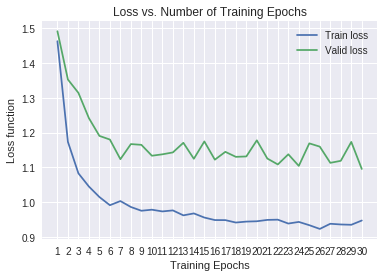

In [0]:
plot_losses(history, conf_epochs)

### Saving the checkpoint

In [0]:
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_class_to_idx': model.class_to_idx,
             }
torch.save(checkpoint, filename)

### Loading the checkpoint

In [0]:
def load_model(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    model, optimizer, parameters = select_pretrained_model(pretrained_model)
            
    model.class_to_idx = checkpoint['model_class_to_idx']
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

In [0]:
model = load_model(filename)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


### Fine-tuning unfreezed layers

In [0]:
model.to(device) 

for param in model.parameters():
    param.requires_grad = True
        
if conf_optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=unfreeze_lr)
if conf_optimizer == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=unfreeze_lr, momentum=0.9)

In [0]:
model, history_ft = train_model(model, criterion, optimizer, num_epochs=unfreeze_epochs, is_inception=is_inception)

Epoch 1/30
----------
train Loss: 0.6939 Acc: 0.5724
valid Loss: 0.6394 Acc: 0.7879
Checkpoint saved at: 0.787913

Epoch 2/30
----------
train Loss: 0.4940 Acc: 0.6382
valid Loss: 0.5006 Acc: 0.8356
Checkpoint saved at: 0.835638

Epoch 3/30
----------
train Loss: 0.4202 Acc: 0.6624
valid Loss: 0.4341 Acc: 0.8535
Checkpoint saved at: 0.853479

Epoch 4/30
----------
train Loss: 0.3696 Acc: 0.6783
valid Loss: 0.3856 Acc: 0.8740
Checkpoint saved at: 0.873996

Epoch 5/30
----------
train Loss: 0.3265 Acc: 0.6936
valid Loss: 0.3743 Acc: 0.8738

Epoch 6/30
----------
train Loss: 0.2957 Acc: 0.7037
valid Loss: 0.3362 Acc: 0.8858
Checkpoint saved at: 0.885816

Epoch 7/30
----------
train Loss: 0.2745 Acc: 0.7099
valid Loss: 0.3115 Acc: 0.9005
Checkpoint saved at: 0.900535

Epoch 8/30
----------
train Loss: 0.2536 Acc: 0.7175
valid Loss: 0.2834 Acc: 0.9028
Checkpoint saved at: 0.902765

Epoch 9/30
----------
train Loss: 0.2439 Acc: 0.7184
valid Loss: 0.2686 Acc: 0.9106
Checkpoint saved at: 0.910

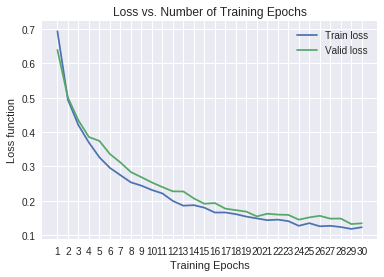

In [0]:
plot_losses(history_ft, unfreeze_epochs)

### Save the checkpoint

In [0]:
## Save the checkpoint
## https://pytorch.org/tutorials/beginner/saving_loading_models.html
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_class_to_idx': model.class_to_idx,
             }
torch.save(checkpoint, 'ft_' + filename)

### Train more epochs

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Epoch 1/10
----------
train Loss: 0.1150 Acc: 0.7612
valid Loss: 0.1314 Acc: 0.9561
Checkpoint saved at: 0.956066

Epoch 2/10
----------
train Loss: 0.1150 Acc: 0.7616
valid Loss: 0.1229 Acc: 0.9612
Checkpoint saved at: 0.961195

Epoch 3/10
----------
train Loss: 0.1169 Acc: 0.7604
valid Loss: 0.1392 Acc: 0.9538

Epoch 4/10
----------
train Loss: 0.1127 Acc: 0.7622
valid Loss: 0.1276 Acc: 0.9601

Epoch 5/10
----------
train Loss: 0.1134 Acc: 0.7624
valid Loss: 0.1351 Acc: 0.9552

Epoch 6/10
----------
train Loss: 0.1109 Acc: 0.7638
valid Loss: 0.1296 Acc: 0.9603

Epoch 7/10
----------
train Loss: 0.1093 Acc: 0.7635
valid Loss: 0.1324 Acc: 0.9576

Epoch 8/10
----------
train Loss: 0.1071 Acc: 0.7640
valid Loss: 0.1375 Acc: 0.9534

Epoch 9/10
----------
train Loss: 0.1087 Acc: 0.7640
valid Loss: 0.1290 Acc: 0.9581

Epoch 10/10
----------
train Loss: 0.1055 Acc: 0.7639
valid Loss: 0.1241 Acc: 0.9581

Training complete in 81m 12s
Best valid accuracy: 0.961195


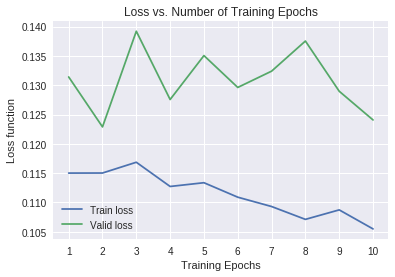

In [0]:
## Train more epochs
train_more = True

if train_more == True:
    model = load_model('ft_' + filename)
    model.to(device) 

    for param in model.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=0.000001)
    add_epochs = 10
    
    model, history_ft = train_model(model, criterion, optimizer, num_epochs=add_epochs, is_inception=is_inception)
    
    plot_losses(history_ft, add_epochs)
    
    model.class_to_idx = image_datasets['train'].class_to_idx
    model.cpu()
    checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'model_class_to_idx': model.class_to_idx,
                 }
    torch.save(checkpoint, 'ft_' + filename)

## 6. Inference for classification

In [0]:
# !wget -cq --no-check-certificate 'https://drive.google.com/uc?export=download&id=13KreFaLe_BljBgp-L-JgrfkMGADOezz-' -O ft_v10_densenet121_batchsize24_optimizerAdam_lr0.001_epochs30_unfreezelr1e-05ep30_.pt

In [0]:
model = load_model('ft_' + filename)
# model = load_model(filename)


''' Remember that you must call model.eval() to set dropout and batch 
    normalization layers to evaluation mode before running inference. 
    
    Failing to do this will yield inconsistent inference results.
'''
model.eval()

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

### Image preprocessing

In [0]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    img = Image.open(image_path)
    
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, size+32))
    else:
        img.thumbnail((size+32, 10000))
        
    # Crop 
    left_margin = (img.width-size)/2
    bottom_margin = (img.height-size)/2
    right_margin = left_margin + size
    top_margin = bottom_margin + size
    
    img = img.crop((left_margin, 
                    bottom_margin, 
                    right_margin,   
                    top_margin))
    # Normalize
    img = np.array(img)/(size+31)
    mean = np.array(mean_array) #provided mean
    std = np.array(std_array) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array(mean_array)
    std = np.array(std_array)
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

### Class prediction

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
        # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    model.cpu()
    probs = F.softmax(model(model_input), dim=1)
    
    # Top probs
    top_probs, top_labs = probs.topk(topk)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
        
    # Convert indices to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [0]:
image_path = 'train/c0/img_100026.jpg'

probs, classes, flowers = predict(image_path, model)
print(probs)
print(flowers)

[0.9999794363975525, 9.480095286562573e-06, 9.448936907574534e-06, 1.0667599781299941e-06, 2.9428676384668506e-07]
['safe driving', 'operating the radio', 'talking to passenger', 'hair and makeup', 'talking on the phone - left']


### Sanity check

In [0]:
### Display an image along with the top 5 classes
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    ax.axis('off')
    
    # Set up title
    flower_num = image_path.split('/')[1]
    title_ = label_map[flower_num]
    
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    print(probs)
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

[0.9999794363975525, 9.480095286562573e-06, 9.448936907574534e-06, 1.0667599781299941e-06, 2.9428676384668506e-07]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


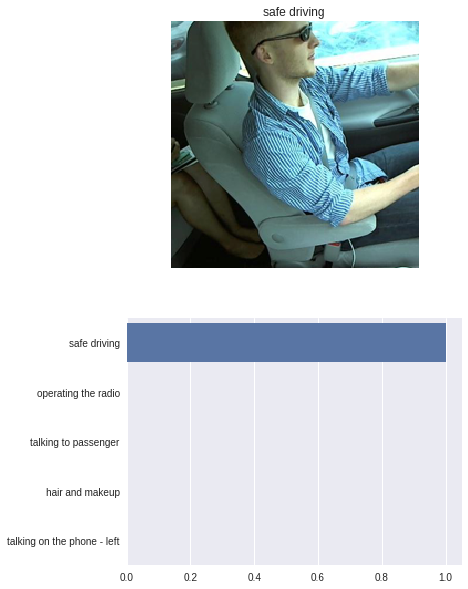

In [0]:
# c0 save driving
image_path = 'train/c0/img_100026.jpg'
plot_solution(image_path, model)

[0.9999842047691345, 1.2577520465129055e-05, 1.947595819729031e-06, 7.259832273120992e-07, 3.0634035397270054e-07]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


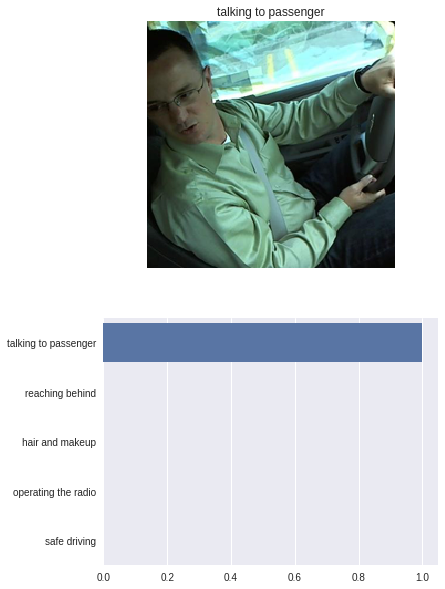

In [0]:
image_path = 'train/c9/img_100090.jpg'
plot_solution(image_path, model)

### Sanity check with unlabeled test dataset

In [0]:
### Display an image along with the top 5 classes
def plot_test_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    ax.axis('off')
    
    # Set up title
#     flower_num = image_path.split('/')[1]
#     print(flower_num)
#     title_ = label_map[flower_num]
    
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax);
    
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    print(probs)
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

[0.9997504353523254, 0.00013373137335292995, 5.9726233303081244e-05, 1.6544130630791187e-05, 1.5641542631783523e-05]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


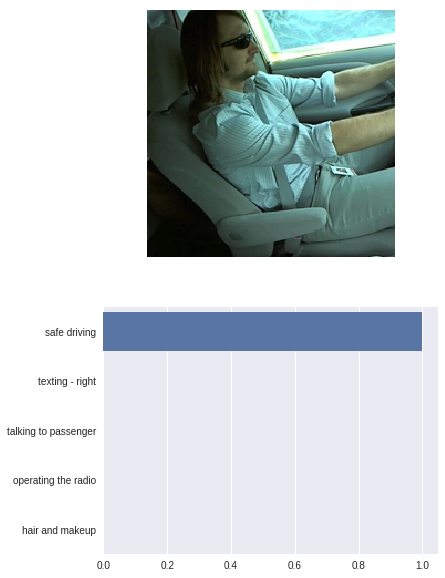

In [0]:
# c0: safe driving
image_path = 'test/img_112.jpg'
plot_test_solution(image_path, model)

[0.9997190833091736, 0.000130371525301598, 0.00012031240476062521, 9.484345355303958e-06, 8.70441181177739e-06]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


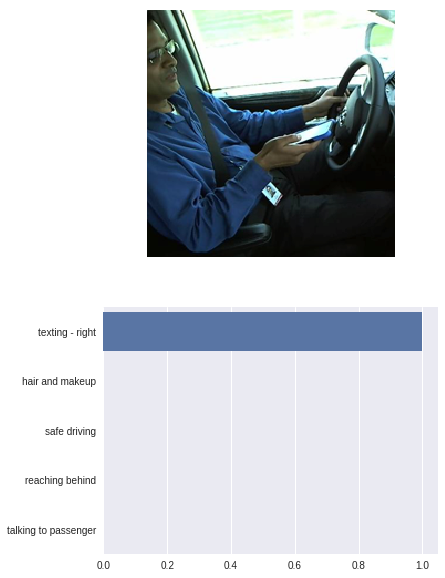

In [0]:
# c1 texting right
image_path = 'test/img_2183.jpg'
plot_test_solution(image_path, model)

[0.9421473145484924, 0.0576133206486702, 0.000102593818155583, 7.828736124793068e-05, 2.7651700293063186e-05]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


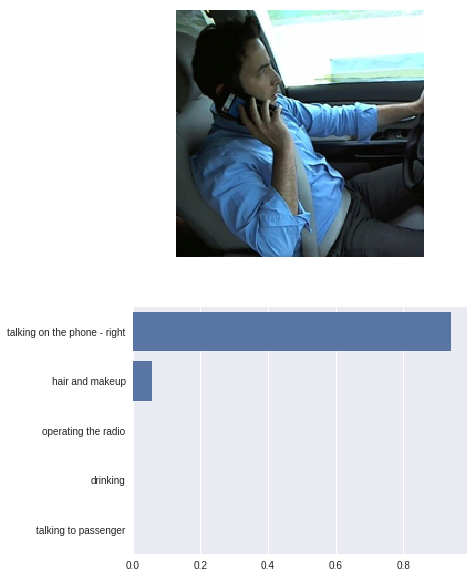

In [0]:
# c2: talking on the phone - right
image_path = 'test/img_48653.jpg'
plot_test_solution(image_path, model)

[0.7309380173683167, 0.2613609731197357, 0.00373470108024776, 0.001951724523678422, 0.0018640152411535382]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


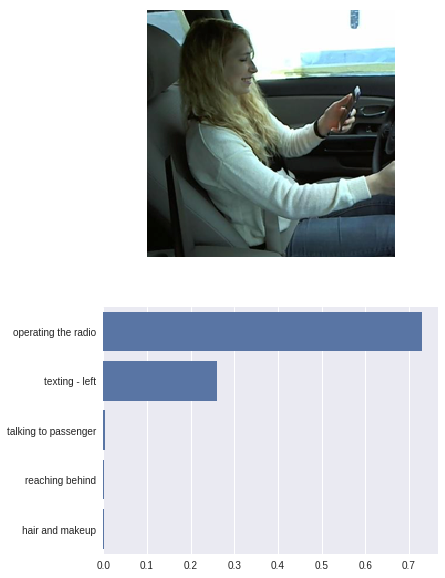

In [0]:
# c3: texting - left
image_path = 'test/img_100013.jpg'
plot_test_solution(image_path, model)

[0.7623791098594666, 0.2365911304950714, 0.00031844625482335687, 0.0002901255211327225, 0.00020909424347337335]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


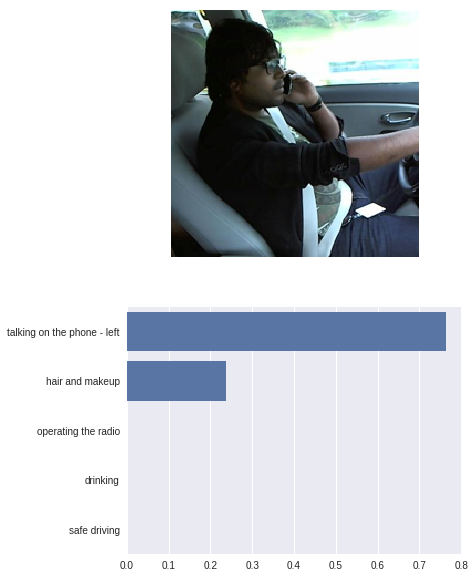

In [0]:
# c4: talking on the phone - left
image_path = 'test/img_100007.jpg'
plot_test_solution(image_path, model)

[0.9989161491394043, 0.0006996382726356387, 0.00038137202500365674, 9.157192835118622e-07, 6.983133857829671e-07]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


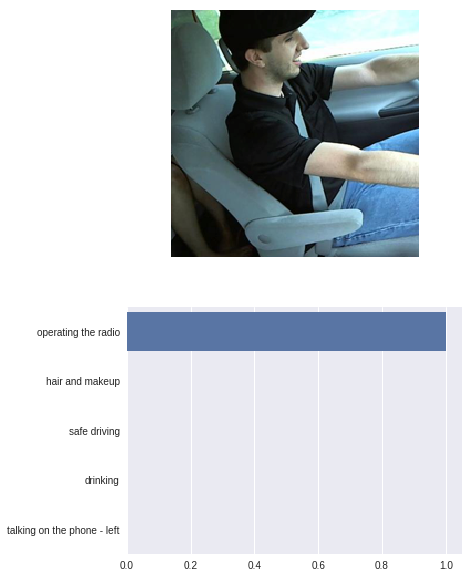

In [0]:
# c5: operating the radio
image_path = 'test/img_10.jpg'
plot_test_solution(image_path, model)

[0.9624881744384766, 0.022080818191170692, 0.015350248664617538, 3.368933903402649e-05, 2.02134015125921e-05]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


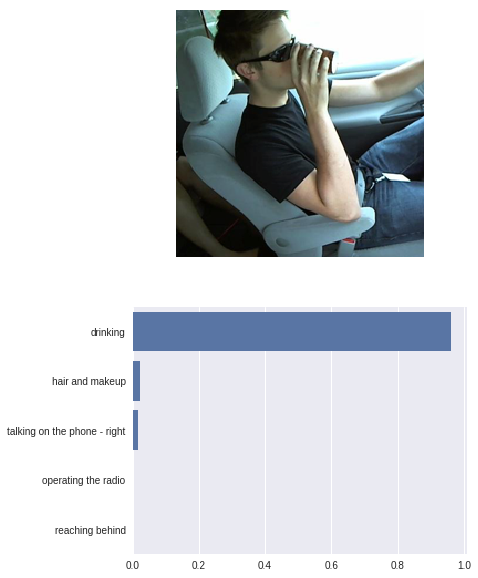

In [0]:
# c6: drinking
image_path = 'test/img_100004.jpg'
plot_test_solution(image_path, model)

[0.9999960660934448, 2.3731777218927164e-06, 5.903054329792212e-07, 5.379966978580342e-07, 1.6016207382563152e-07]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


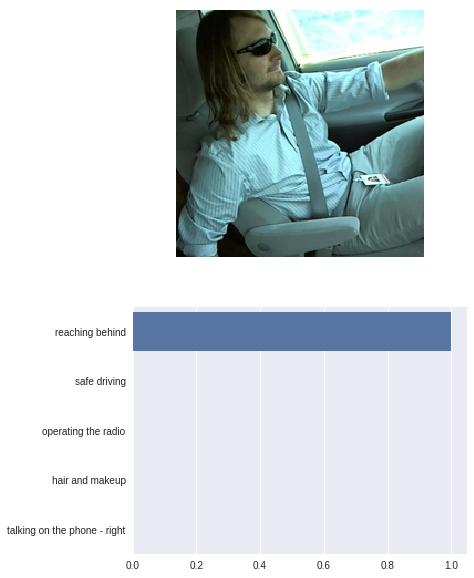

In [0]:
# c7: reaching behind
image_path = 'test/img_100005.jpg'
plot_test_solution(image_path, model)

[0.9979269504547119, 0.0008682761108502746, 0.0004634092911146581, 0.00022698298562318087, 0.00021720322547480464]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


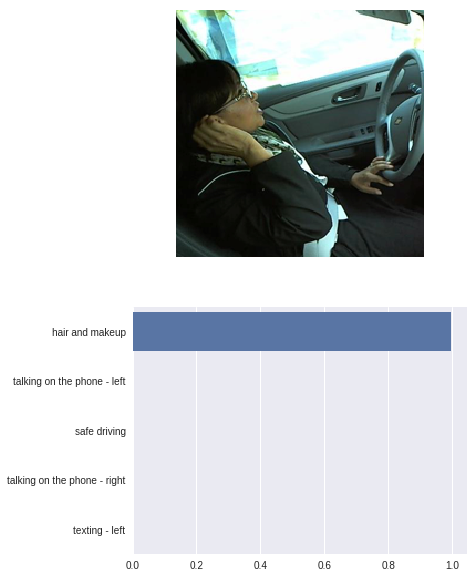

In [0]:
# c8: hair and makeup
image_path = 'test/img_47520.jpg'
plot_test_solution(image_path, model)

[0.9453031420707703, 0.052802566438913345, 0.0017033485928550363, 0.0001394970458932221, 3.412623118492775e-05]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


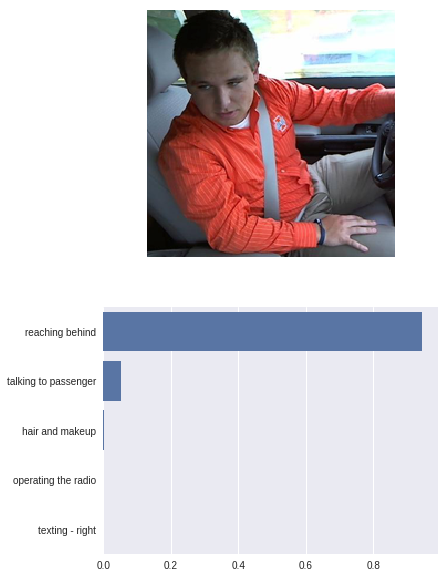

In [0]:
# c9: talking to passenger
image_path = 'test/img_13367.jpg'
plot_test_solution(image_path, model)

[0.9802523255348206, 0.008602608926594257, 0.007010024506598711, 0.0029753120616078377, 0.0010338982101529837]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


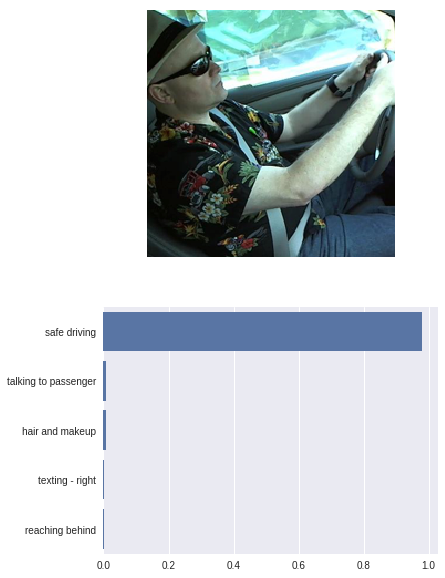

In [0]:
# Error due to sunglasses
image_path = 'test/img_100.jpg'
plot_test_solution(image_path, model)

[0.9887715578079224, 0.010183378122746944, 0.0007438856409862638, 0.00014281581388786435, 0.00010919617488980293]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


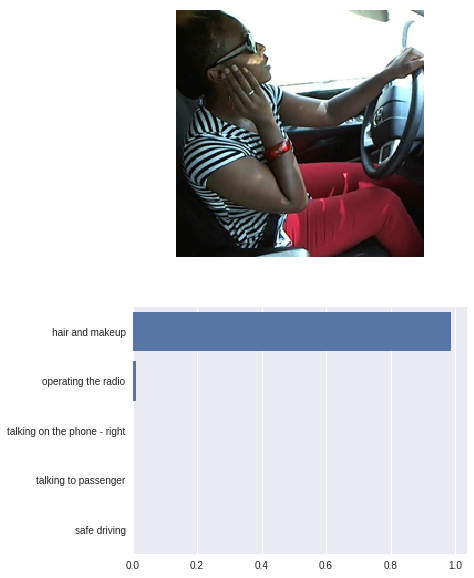

In [0]:
# Error
image_path = 'test/img_1000.jpg'
plot_test_solution(image_path, model)

[0.7585799694061279, 0.17706802487373352, 0.03838919475674629, 0.02532021701335907, 0.0005466139409691095]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


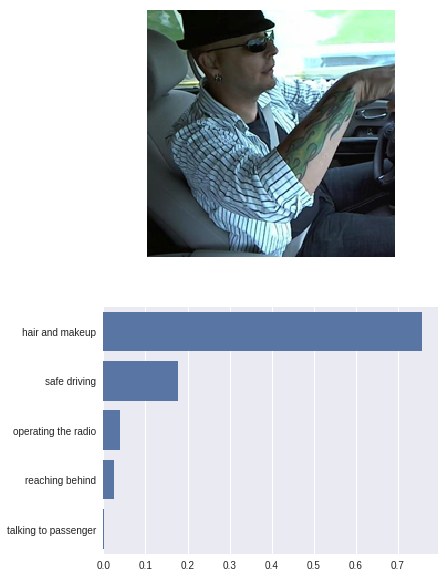

In [0]:
# Error
image_path = 'test/img_10022.jpg'
plot_test_solution(image_path, model)

### Kaggle Upload Function


In [0]:
def predict_submission(image_path, model, topk=10):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
        # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    model.cpu()
    probs = F.softmax(model(model_input), dim=1)
    
    # Top probs
    top_probs, top_labs = probs.topk(topk)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    return top_probs, top_labs

In [0]:
import os
test_images = os.listdir('test')

df = pd.DataFrame()

for image in test_images:
    probs, classes = predict_submission('test/'+image, model)
    x = {'img': image}
    y = {x: probs[classes.index(x)] for x in classes}
    df = df.append({**x, **y}, ignore_index=True)

df.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'img']
df = df.set_index('img')
print(df)
df.to_csv(version + '_kaggle_submission.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  # Remove the CWD from sys.path while we load stuff.


                          c0            c1            c2            c3  \
img                                                                      
img_63226.jpg   6.589249e-10  4.088561e-12  1.506807e-09  6.117487e-11   
img_1544.jpg    2.083617e-04  1.680706e-08  3.075507e-08  5.194830e-05   
img_43259.jpg   1.216922e-03  8.034899e-06  2.001173e-05  6.606203e-06   
img_4889.jpg    5.823451e-02  9.296019e-07  4.385143e-04  8.502320e-08   
img_24180.jpg   7.001089e-05  1.669935e-05  1.971757e-06  2.433025e-07   
img_97857.jpg   3.943874e-02  4.345622e-05  4.759172e-06  8.226818e-01   
img_24381.jpg   6.165802e-01  4.777753e-05  7.633823e-05  2.490124e-03   
img_54262.jpg   3.964662e-04  5.341848e-05  6.415075e-08  9.993868e-01   
img_81846.jpg   3.863610e-08  5.702655e-08  2.931094e-08  6.335679e-07   
img_64528.jpg   2.528814e-03  1.440929e-04  5.351958e-04  7.046068e-04   
img_44435.jpg   3.380210e-06  3.131213e-07  5.712028e-06  5.174422e-08   
img_69326.jpg   6.229111e-10  4.224614